In [20]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import pandas as pd #for reading csv files
from sklearn.model_selection import GridSearchCV
from scipy.io import loadmat
import os
import matplotlib.pyplot as plt
import mat73
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor

In [21]:
# Path to the folders containing the .mat files
test_folder = "Test"
train_folder = "Train"

x_train_data = {}
y_train_data = {}

y_train_columns = ['PumpHead','FinalGear','CouplingOil','Lamella','Coupling','ActWinding','Mosfet']

In [22]:
x_columns = ['OutsideTemp','VehicleVel','OmegaHLSC','GearPower','InfoCtrl1__PCBTemp']

# Read .mat files from the Train folder
for file in os.listdir(train_folder):
    if file.endswith(".mat") and not file.startswith("data_"):
        x_train_file = os.path.join(train_folder, file)
        y_train_file = os.path.join(train_folder, "data_" + file)

        # Add y train data
        mat_data = loadmat(y_train_file)
        # Iterate over each element in the struct
        for column in y_train_columns:
            flattened_column = mat_data['Temperature'][0,0][column].flatten()

            if column in y_train_data:
                y_train_data[column] = np.concatenate([y_train_data[column], flattened_column])
            else:
                y_train_data[column] = flattened_column

        # Add x train data
        mat_data = mat73.loadmat(x_train_file)
        for column in x_columns:
            # Trim 100 sample in the beginning and the end of the data
            flattened_column = mat_data[column][100:-100,1].flatten()
    
            if column in x_train_data:
                x_train_data[column] = np.concatenate([x_train_data[column], flattened_column])
            else:
                x_train_data[column] = flattened_column
        
        # To handle when train data has columns with different length
        min_len_x_train = min([len(x_train_data[x_columns[i]]) for i in range(len(x_columns))])
        min_len_y_train = min([len(y_train_data[y_train_columns[i]]) for i in range(len(y_train_columns))])
        # Take data till min_len_x_train
        for column in x_columns:
            x_train_data[column] = x_train_data[column][:min_len_x_train]
        # Take data till min_len_y_train
        for column in y_train_columns:
            y_train_data[column] = y_train_data[column][:min_len_y_train]

        # Make sure x_train_data and y_train_data have the same size
        if min_len_x_train > min_len_y_train:
            for column in x_columns:
                x_train_data[column] = x_train_data[column][:min_len_y_train]
        
        elif min_len_x_train < min_len_y_train:
            for column in y_train_columns:
                y_train_data[column] = y_train_data[column][:min_len_x_train]


In [23]:
x_test_data = {}
y_test_data = {}
y_matlab_predict = {}
y_test_columns = ['PumpHead','FinalGear','CouplingOil','Lamella','Coupling','ActWinding','Mosfet']
y_matlab_columns = ['EstPumpHead','EstFinalGear','EstCouplingOil','EstLamella','EstCoupling','EstActWinding','EstMosfet']

x_columns = ['OutsideTemp','VehicleVel','OmegaHLSC','GearPower','InfoCtrl1__PCBTemp']
# Read .mat files from the Test folder
# for file in os.listdir(test_folder):
#     if file.endswith(".mat") and not file.startswith("data_"):
file = "220309_45minCity_1hcooling.mat"
x_test_file = os.path.join(test_folder, file)
y_test_file = os.path.join(test_folder, "data_" + file)

# Add y test data
mat_data = loadmat(y_test_file)
# Iterate over each element in the struct
for column in y_test_columns:
    flattened_column = mat_data['Temperature'][0,0][column].flatten()

    if column in y_test_data:
        y_test_data[column] = np.concatenate([y_test_data[column], flattened_column])
    else:
        y_test_data[column] = flattened_column

for column in y_matlab_columns:
    flattened_column = mat_data['Temperature'][0,0][column].flatten()

    if column in y_matlab_predict:
        y_matlab_predict[column] = np.concatenate([y_matlab_predict[column], flattened_column])
    else:
        y_matlab_predict[column] = flattened_column

# Add x test data
mat_data = mat73.loadmat(x_test_file)
for column in x_columns:
    flattened_column = mat_data[column][100:-100,1].flatten()

    if column in x_test_data:
        x_test_data[column] = np.concatenate([x_test_data[column], flattened_column])
    else:
        x_test_data[column] = flattened_column

# To handle when test data has columns with different length
min_len_x_test = min([len(x_test_data[x_columns[i]]) for i in range(len(x_columns))])
min_len_y_test = min([len(y_test_data[y_test_columns[i]]) for i in range(len(y_test_columns))])
# Take data till min_len_x_test
for column in x_columns:
    x_test_data[column] = x_test_data[column][:min_len_x_test]
# Take data till min_len_y_test
for column in y_test_columns:
    y_test_data[column] = y_test_data[column][:min_len_y_test]

# Make sure x_test_data and y_test_data have the same size

if min_len_x_test > min_len_y_test:
    for column in x_columns:
        x_test_data[column] = x_test_data[column][:min_len_y_test]

elif min_len_x_test < min_len_y_test:
    for column in y_test_columns:
        y_test_data[column] = y_test_data[column][:min_len_x_test]
    for column in y_matlab_columns:
        y_matlab_predict[column] = y_matlab_predict[column][:min_len_x_test]

In [24]:
print(min_len_x_train)
print(min_len_y_train)
print(min_len_x_test)
print(min_len_y_test)

4146437
4146437
372919
372919


In [25]:
xtrain = pd.DataFrame(x_train_data)
X_train = xtrain.loc[:,x_columns].values
X_train.shape

(4146437, 5)

In [26]:
ytrain = pd.DataFrame(y_train_data)
Y_train = ytrain.loc[:,y_train_columns].values
Y_train.shape

(4146437, 7)

In [27]:
xtest = pd.DataFrame(x_test_data)
X_test = xtest.loc[:,x_columns].values

ytest = pd.DataFrame(y_test_data)
Y_test = ytest.loc[:,y_test_columns].values

In [28]:
ymatlab = pd.DataFrame(y_matlab_predict)
Y_matlab = ymatlab.loc[:,y_matlab_columns].values
Y_matlab = Y_matlab + 273
Y_matlab.shape

(372919, 7)

In [29]:
from sklearn.preprocessing import MinMaxScaler

x_scaler = MinMaxScaler()
X_train_normalized = x_scaler.fit_transform(X_train)
X_test_normalized = x_scaler.transform(X_test)
X_train_normalized.shape



(4146437, 5)

In [30]:
y_scaler = MinMaxScaler()
Y_train_normalized = y_scaler.fit_transform(Y_train)
Y_train_normalized.shape

(4146437, 7)

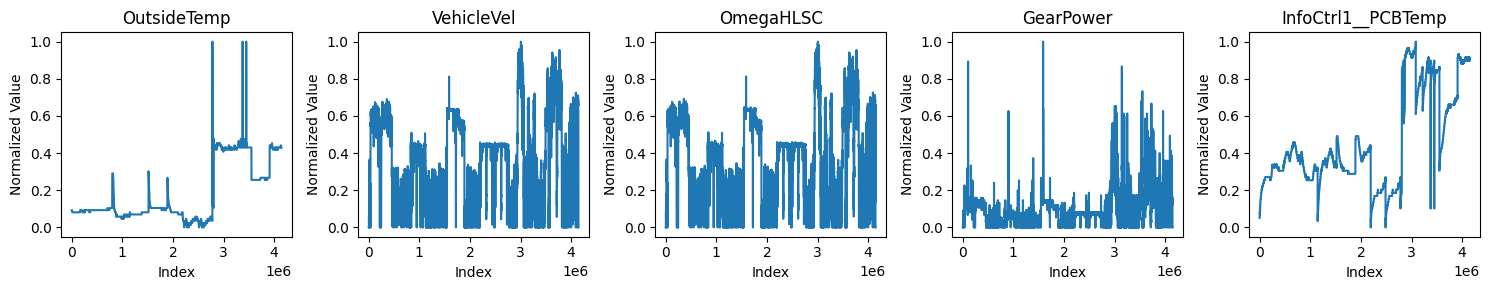

In [31]:
# Number of plots and columns
num_plots = X_train_normalized.shape[1]
num_cols = 5

# Calculate number of rows needed
num_rows = (num_plots + num_cols - 1) // num_cols

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3 * num_rows))

# Flatten the axes for easy iteration
axes = axes.flatten()

# Plot each column with corresponding title
for i in range(num_plots):
    axes[i].plot(X_train_normalized[:, i])
    axes[i].set_title(x_columns[i])
    axes[i].set_xlabel('Index')
    axes[i].set_ylabel('Normalized Value')

# Hide empty subplots
for j in range(num_plots, num_rows * num_cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

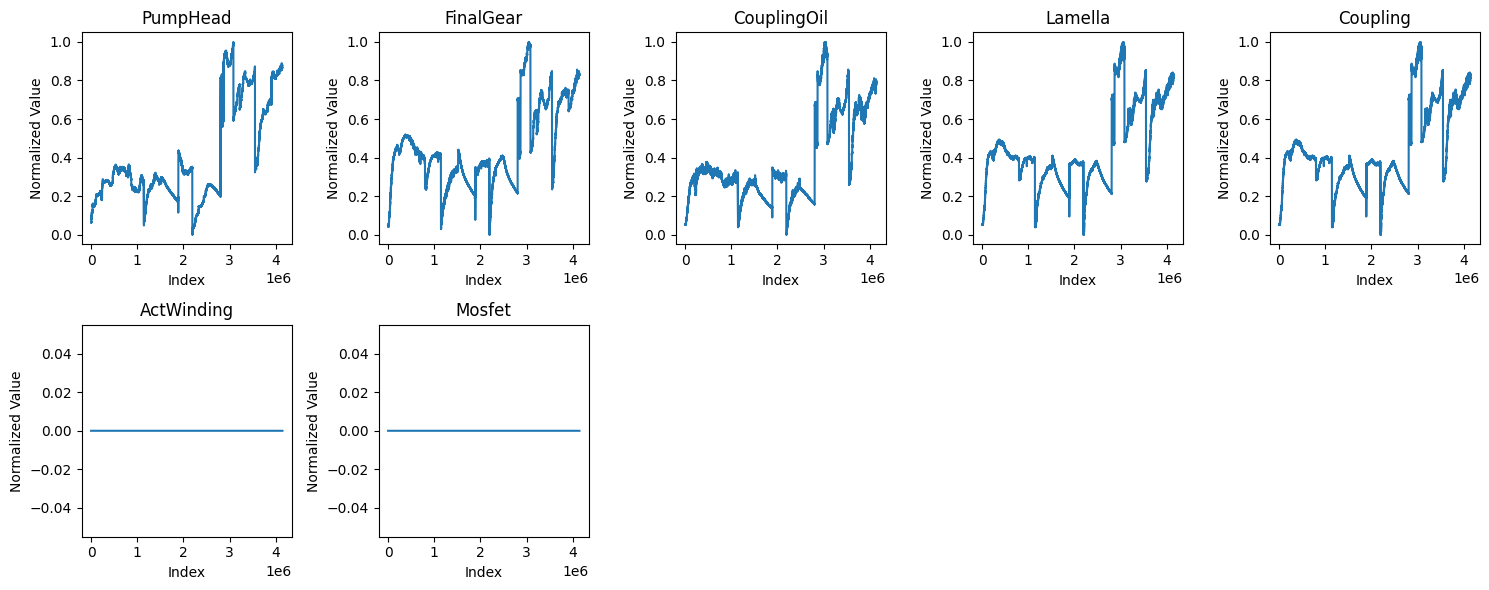

In [32]:
# Number of plots and columns
num_plots = Y_train_normalized.shape[1]
num_cols = 5

# Calculate number of rows needed
num_rows = (num_plots + num_cols - 1) // num_cols

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3 * num_rows))

# Flatten the axes for easy iteration
axes = axes.flatten()

# Plot each column with corresponding title
for i in range(num_plots):
    axes[i].plot(Y_train_normalized[:, i])
    axes[i].set_title(y_train_columns[i])
    axes[i].set_xlabel('Index')
    axes[i].set_ylabel('Normalized Value')

# Hide empty subplots
for j in range(num_plots, num_rows * num_cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [33]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
X_train_split, X_val_split, Y_train_split, Y_val_split = train_test_split(
    X_train_normalized, Y_train_normalized, test_size=0.2, random_state=42
)

Epoch 1/15
103661/103661 [==============================] - 199s 2ms/step - loss: 0.0015 - val_loss: 0.0010
Epoch 2/15
103661/103661 [==============================] - 198s 2ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 3/15
103661/103661 [==============================] - 206s 2ms/step - loss: 0.0010 - val_loss: 0.0011
Epoch 4/15
103661/103661 [==============================] - 208s 2ms/step - loss: 0.0010 - val_loss: 0.0018
Epoch 5/15
103661/103661 [==============================] - 210s 2ms/step - loss: 0.0010 - val_loss: 0.0021
Epoch 6/15
103661/103661 [==============================] - 188s 2ms/step - loss: 0.0010 - val_loss: 0.0017
Epoch 7/15
103661/103661 [==============================] - 179s 2ms/step - loss: 9.9924e-04 - val_loss: 0.0017
Epoch 8/15
103661/103661 [==============================] - 141s 1ms/step - loss: 9.9420e-04 - val_loss: 0.0017
Epoch 9/15
103661/103661 [==============================] - 143s 1ms/step - loss: 9.8597e-04 - val_loss: 0.0019
Epoch 10/15
1036

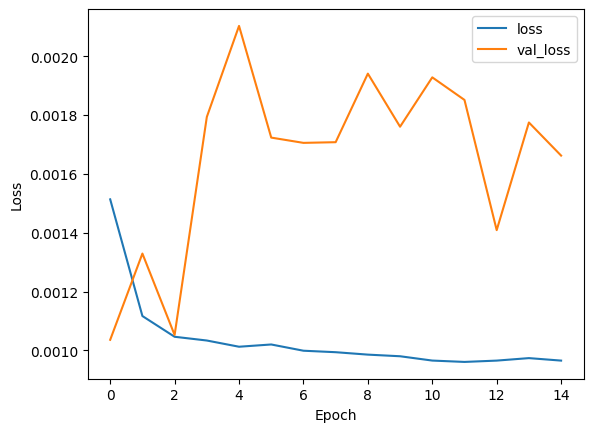

In [34]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam

# Define a neural network using TensorFlow and Keras
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_normalized.shape[1],)),
    Dropout(0.13),
    # Hidden layers
    Dense(128, activation='relu'),
    Dropout(0.13),
    Dense(128, activation='relu'),
    Dropout(0.13),
    Dense(64, activation='relu'),
    Dense(len(y_train_columns))  # Output layer
])

learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)
# Compile the model
model.compile(optimizer=optimizer, loss='mse')

# Train the model and get the history
history = model.fit(X_train_split, Y_train_split, epochs=15, batch_size=32, validation_data=(X_val_split, Y_val_split))

# Training history
plt.figure()
plt.ylabel('Loss')
plt.xlabel('Epoch')
for k in history.history.keys():
    plt.plot(history.history[k], label=k)
plt.legend(loc='best')
plt.show()


In [35]:
#y_test_columns = ['PumpHead','FinalGear','CouplingOil','Lamella','Coupling','ActWinding','Mosfet']
predictions_normalized = model.predict(X_test_normalized)
print(predictions_normalized.shape)
# Inverse transform the prediction
predictions_original_scale = y_scaler.inverse_transform(predictions_normalized)

11654/11654 [==============================] - 7s 625us/step
(372919, 7)


In [36]:
from keras.models import save_model
import joblib

# Save models
model.save('model_nn.h5')

c:\Users\dvandang\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [37]:
# Save the scaler(s)
joblib.dump(x_scaler, 'x_scaler_nn.joblib')
joblib.dump(y_scaler, 'y_scaler_nn.joblib')

['y_scaler_nn.joblib']

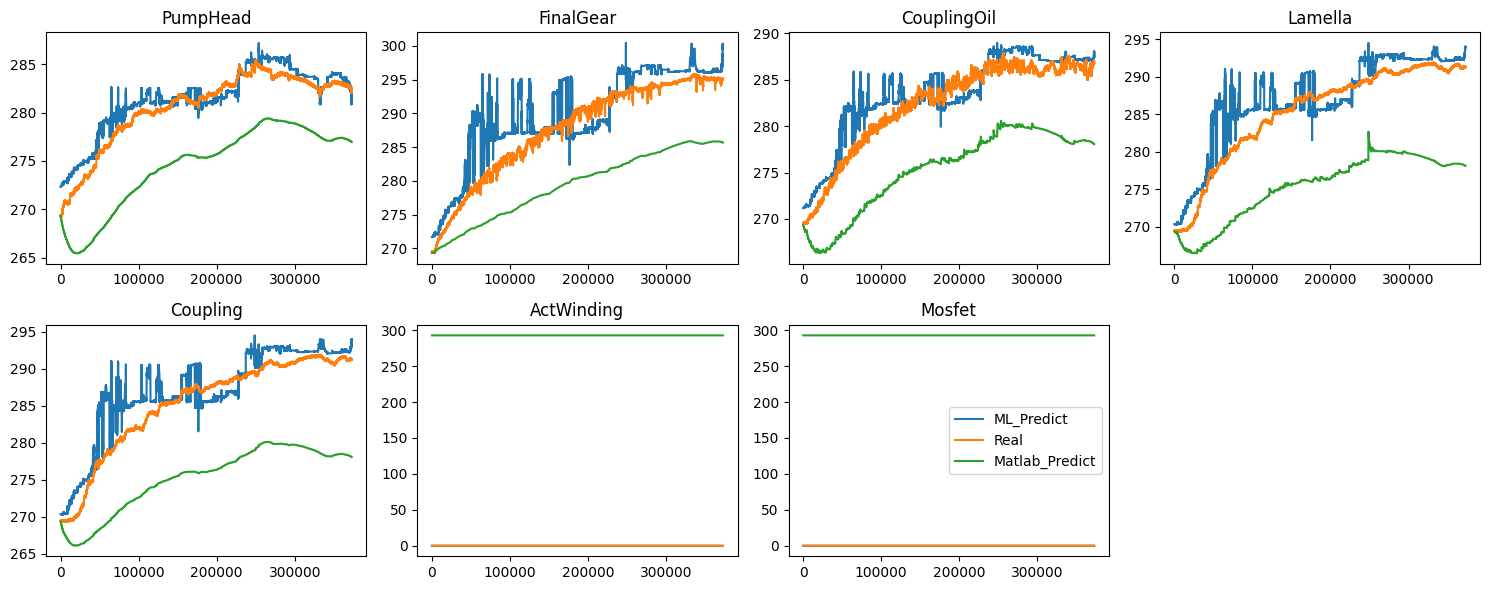

In [38]:
# Number of plots and columns
num_plots = Y_train_normalized.shape[1]
num_cols = 4

# Calculate number of rows needed
num_rows = (num_plots + num_cols - 1) // num_cols

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3 * num_rows))

# Flatten the axes for easy iteration
axes = axes.flatten()

# Plot each column with corresponding title
for i in range(num_plots):
    axes[i].plot(predictions_original_scale[:,i], label='ML_Predict')
    axes[i].plot(Y_test[:, i], label='Real')
    axes[i].plot(Y_matlab[:, i], label='Matlab_Predict')
    axes[i].set_title(y_test_columns[i])

# Hide empty subplots
for j in range(num_plots, num_rows * num_cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.legend()
plt.show()